# 1-D Hamiltonian system doing sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class HamiltonianSystem:
    def __init__(self, potential_func, dV_dx_func, m, t_max, delta_t):
        # Initialize the Hamiltonian system with given parameters
        self.potential = potential_func  # Potential energy function
        self.dV_dx = dV_dx_func  # Derivative of potential energy function
        self.m = m  # Mass of the particle
        self.t_max = t_max  # Maximum simulation time
        self.delta_t = delta_t  # Time step
        self.num_steps = int(t_max / delta_t) + 1  # Number of simulation steps

    def simulate(self, x0, p0):
        # Simulate the Hamiltonian system for given initial conditions
        init_energy = 0.5 * (p0**2) / self.m + self.potential(x0)  # Initial total energy

        x_array = np.zeros(self.num_steps)  # Array to store positions
        p_array = np.zeros(self.num_steps)  # Array to store momenta
        energy_array = np.zeros(self.num_steps)  # Array to store total energy
        t_array = np.linspace(0, self.t_max, self.num_steps)  # Time array

        # Set initial conditions
        x_array[0], p_array[0], energy_array[0] = x0, p0, init_energy

        # Perform simulation using symplectic Euler method
        for i in range(1, self.num_steps):
            p_array[i] = p_array[i - 1] - self.delta_t * self.dV_dx(x_array[i - 1])
            x_array[i] = x_array[i - 1] + self.delta_t * p_array[i] / self.m
            energy_array[i] = 0.5 * (p_array[i] ** 2) / self.m + self.potential(
                x_array[i]
            )

        return t_array, x_array, p_array, energy_array

    def sample_data(self, t_array, x_array, p_array, energy_array):
        # Sample data at regular intervals for plotting
        sample_interval = int(1 / self.delta_t)
        sample_indices = np.arange(0, self.num_steps, sample_interval)
        return [
            arr[sample_indices] for arr in (t_array, x_array, p_array, energy_array)
        ]

    def sample_initial_conditions(self, N, x_bounds=(np.pi / 2, 5 * np.pi / 2)):
        """
        Sample N initial conditions (x0, p0) with probability proportional to exp(-H(x0, p0)),
        where H(x0, p0) = p0^2/(2m) + V(x0).

        Parameters:
            N (int): Number of samples to generate.
            x_bounds (tuple): Bounds for x0 sampling.

        Returns:
            List of tuples: [(x0_1, p0_1), (x0_2, p0_2), ..., (x0_N, p0_N)]
        """
        samples = []
        attempts = 0
        max_attempts = N * 1000  # To prevent infinite loop

        while len(samples) < N and attempts < max_attempts:
            # Sample x0 uniformly within bounds
            x_proposal = np.random.uniform(x_bounds[0], x_bounds[1])
            # Compute acceptance probability for x0
            p_x = np.exp(-self.potential(x_proposal))
            p_x_max = np.exp(-self.potential(x_bounds[0]))  # Since sin(x) has max at pi/2, adjust if necessary
            # For V(x) = sin(x), min V(x) = -1 at 3π/2, so p_x_max = exp(1)
            p_x_max = np.exp(1)

            if np.random.uniform(0, p_x_max) < p_x:
                # Accept x0
                x0 = x_proposal
                # Sample p0 from Gaussian distribution
                p0 = np.random.normal(0, np.sqrt(self.m))
                samples.append((x0, p0))
            attempts += 1

        if len(samples) < N:
            raise RuntimeError(f"Could not generate {N} samples within {max_attempts} attempts.")

        return samples


class Plotter:
    @staticmethod
    def static_plots(t_sampled, x_sampled, p_sampled, energy_sampled, init_energy):
        # Create static plots for the Hamiltonian system
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("Hamiltonian System Dynamics", fontsize=16)

        plots = [
            (
                axs[0, 0],
                t_sampled,
                x_sampled,
                "Position vs Time",
                "Time t",
                "Position x(t)",
                "blue",
            ),
            (
                axs[0, 1],
                t_sampled,
                p_sampled,
                "Momentum vs Time",
                "Time t",
                "Momentum p(t)",
                "red",
            ),
            (
                axs[1, 0],
                x_sampled,
                p_sampled,
                "Phase Space Plot",
                "Position x",
                "Momentum p",
                "green",
            ),
            (
                axs[1, 1],
                t_sampled,
                energy_sampled,
                "Total Energy vs Time",
                "Time t",
                "Total Energy H(t)",
                "purple",
            ),
        ]

        # Create each subplot
        for ax, x, y, title, xlabel, ylabel, color in plots:
            ax.plot(x, y, color=color)
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

        # Adjust energy plot to show conservation
        axs[1, 1].set_ylim(init_energy - 0.1, init_energy + 0.1)
        axs[1, 1].axhline(
            y=init_energy, color="black", linestyle="--", label="Initial Energy"
        )
        axs[1, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    @staticmethod
    def composite_plot(x_sampled, t_sampled, potential_func):
        # Create a composite plot showing particle trajectory and potential energy
        fig, (ax_top, ax_bottom) = plt.subplots(
            2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [2, 1]}, sharex=False
        )
        fig.suptitle("Composite Visualization of Hamiltonian System", fontsize=16)

        x_limit_min, x_limit_max = 0, 4 * np.pi
        ax_top.set_xlim(x_limit_min, x_limit_max)
        ax_bottom.set_xlim(x_limit_min, x_limit_max)

        # Plot particle trajectory
        ax_top.plot(x_sampled, t_sampled, color="blue")
        ax_top.set_title("Particle Trajectory")
        ax_top.set_xlabel("Position x(t)")
        ax_top.set_ylabel("Time t")
        ax_top.grid(True)

        # Plot potential energy function
        x_potential = np.linspace(x_limit_min, x_limit_max, 1000)
        V_potential = potential_func(x_potential)
        ax_bottom.plot(x_potential, V_potential, color="black")
        ax_bottom.set_title("Potential Energy V(x) vs Position x")
        ax_bottom.set_xlabel("Position x")
        ax_bottom.set_ylabel("Potential V(x)")
        ax_bottom.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def verify_confinement(x_sampled, potential_func, epsilon=1e-5):
    # Verify if the particle is confined within potential wells
    # Find the local maxima of the potential function
    x_range = np.linspace(-50, 50, 10000)
    potential_values = potential_func(x_range)
    local_maxima_indices = (
        np.where(
            (potential_values[1:-1] > potential_values[:-2])
            & (potential_values[1:-1] > potential_values[2:])
        )[0]
        + 1
    )
    local_maxima = x_range[local_maxima_indices]

    # Check if the particle crossed any of the local maxima
    crossed_barrier = False
    for i in range(1, len(x_sampled)):
        if any((x_sampled[i-1] - barrier) * (x_sampled[i] - barrier) < 0 for barrier in local_maxima):
            crossed_barrier = True
            break

    print("\n>>> Local maxima of the potential function at:", local_maxima)
    print(
        "\n>>> Particle has {}crossed the potential barrier.".format(
            "" if crossed_barrier else "not "
        )
    )
    
    return local_maxima

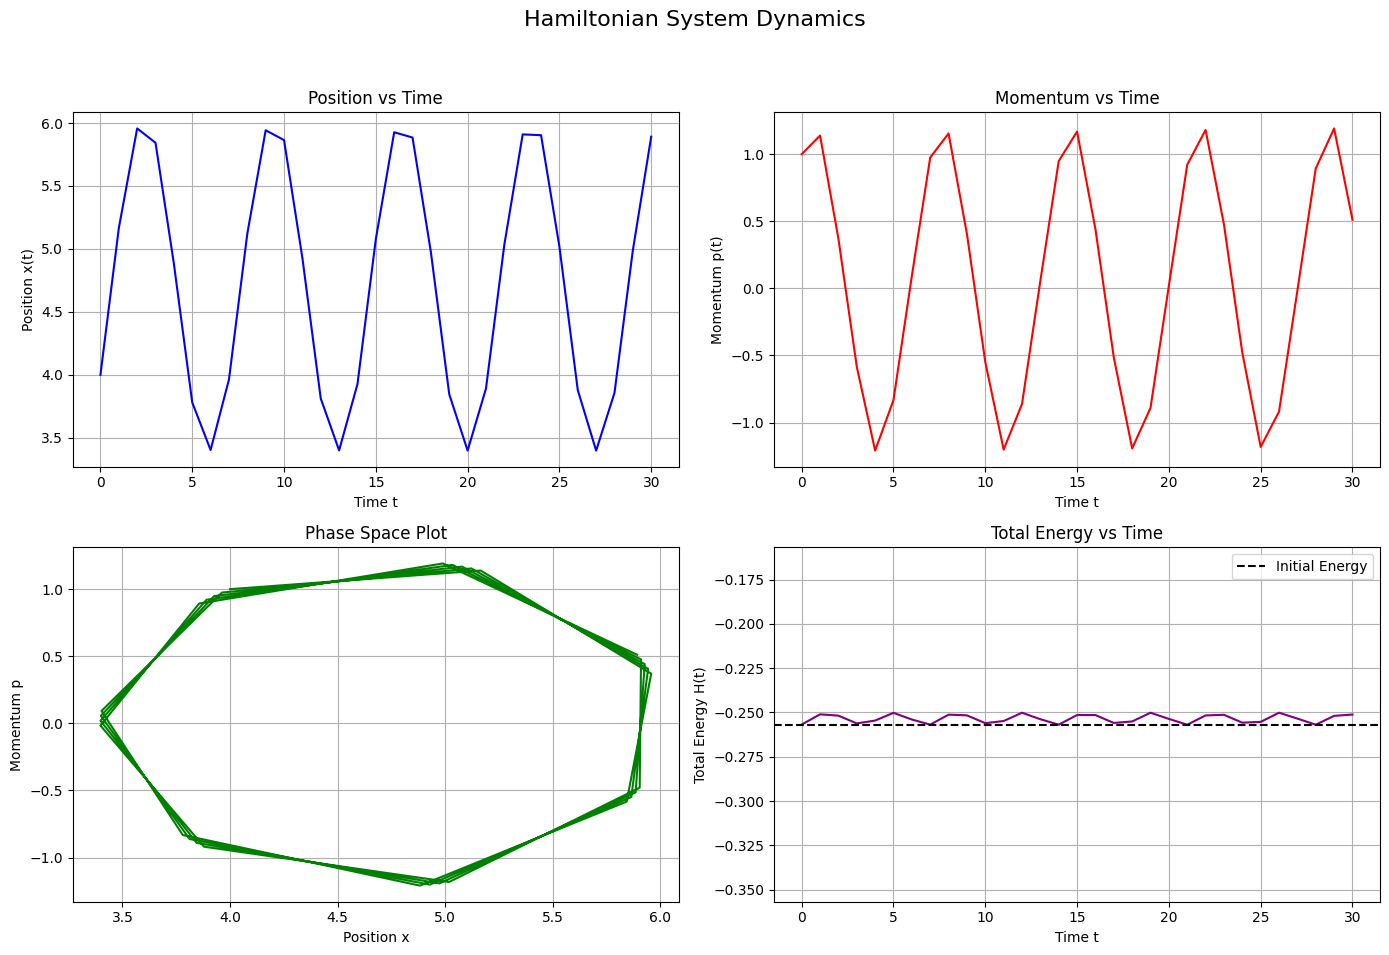

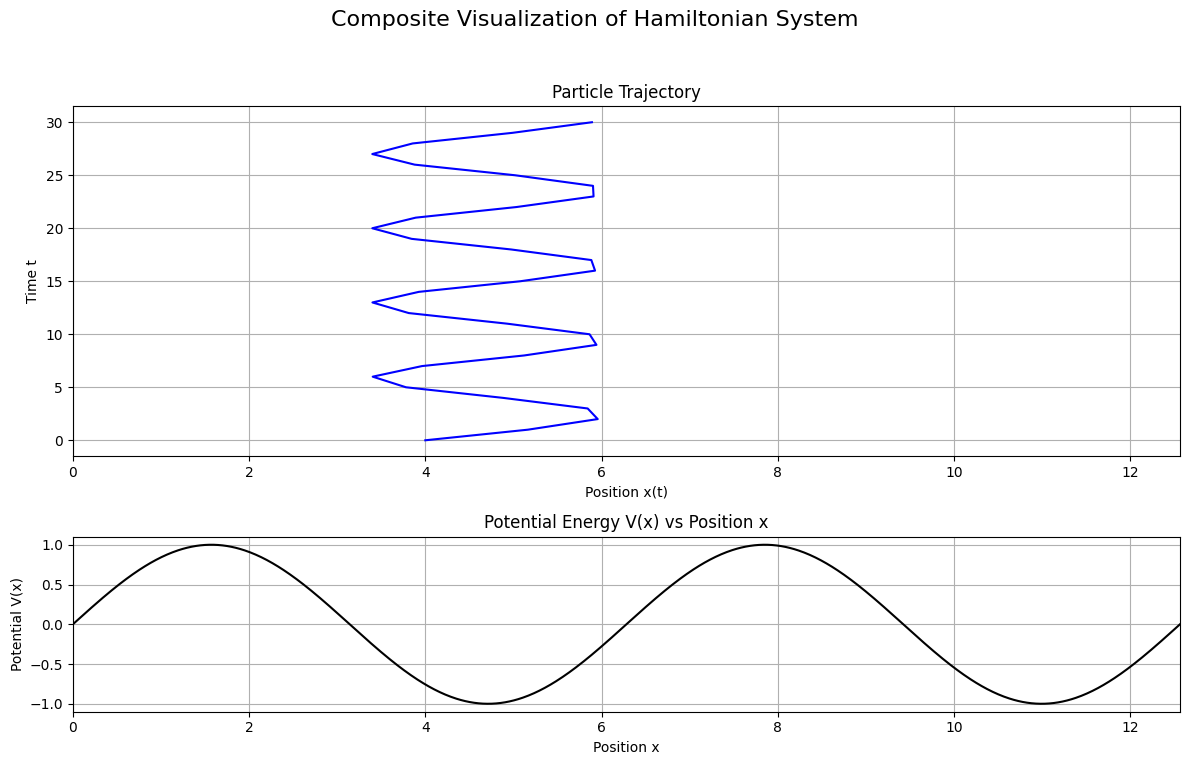


>>> Local maxima of the potential function at: [-48.68986899 -42.40924092 -36.12861286 -29.8479848  -23.55735574
 -17.27672767 -10.99609961  -4.71547155   1.57515752   7.85578558
  14.13641364  20.4170417   26.70767077  32.98829883  39.26892689
  45.54955496]

>>> Particle has not crossed the potential barrier.

>>> Generated 1000 sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))


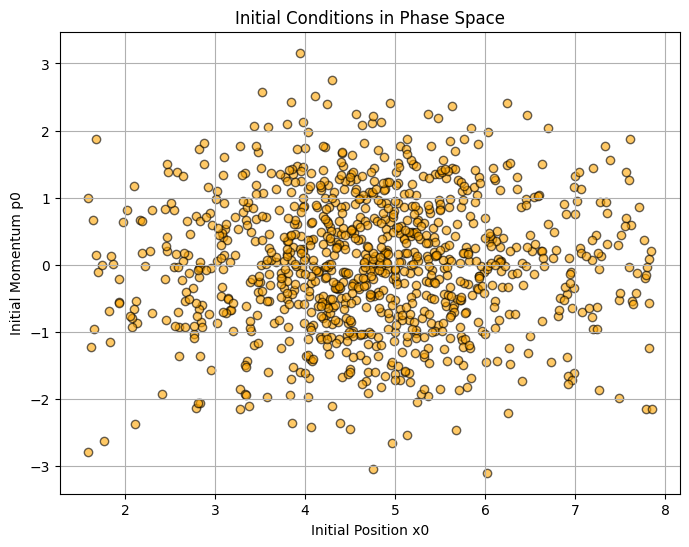


>>> Average number of times crossing the potential maxima: 0.99


In [3]:
def main():
    # Define potential energy function and its derivative
    def potential(x):
        return np.sin(x)

    def dV_dx(x):
        return np.cos(x)

    # Input settings
    m = 1.0  # Mass
    t_max = 30  # Maximum simulation time
    delta_t = 0.01  # Time step

    # Create Hamiltonian system
    system = HamiltonianSystem(potential, dV_dx, m, t_max, delta_t)

    #! Part 1: Single initial condition
    x0_single = 4.0  # Initial position
    p0_single = 1.0  # Initial momentum

    t_array, x_array, p_array, energy_array = system.simulate(x0_single, p0_single)
    t_sampled, x_sampled, p_sampled, energy_sampled = system.sample_data(
        t_array, x_array, p_array, energy_array
    )

    # plot charts 
    plotter = Plotter()
    plotter.static_plots(
        t_sampled, x_sampled, p_sampled, energy_sampled, 0.5 * (p0_single**2) / m + system.potential(x0_single)
    )
    plotter.composite_plot(x_sampled, t_sampled, potential)

    # verify whether the particle is confined 
    local_maxima = verify_confinement(x_sampled, potential)

    #! Part 2: generate a set of initial conditions
    N = 1000  # length of the set
    sampled_initial_conditions = system.sample_initial_conditions(N)

    print(f"\n>>> Generated {N} sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))")

    # visualize the initial conditions in phase space
    x0_samples, p0_samples = zip(*sampled_initial_conditions)
    plt.figure(figsize=(8, 6))
    plt.scatter(x0_samples, p0_samples, color='orange', alpha=0.6, edgecolor='k')
    plt.title("Initial Conditions in Phase Space")
    plt.xlabel("Initial Position x0")
    plt.ylabel("Initial Momentum p0")
    plt.grid(True)
    plt.show()

    # calculate the times of crossing the potential maxima for each initial condition, then average them
    times_of_crossing = []
    for x0, p0 in sampled_initial_conditions:
        t_array, x_array, p_array, energy_array = system.simulate(x0, p0)
        
        # Count how many times the particle crosses the local maxima
        crossings = 0
        for i in range(1, len(x_array)):
            for max_x in local_maxima:
                if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                    crossings += 1
        times_of_crossing.append(crossings)
    
    average_crossings = np.mean(times_of_crossing)
    print(f"\n>>> Average number of times crossing the potential maxima: {average_crossings:.2f}")

if __name__ == "__main__":
    main()